# Imports

Started up by running shawnhammer in a terminal. Running on slot 4, /home/cryo/docker/pysmurf/dev/v5.0.2, rogue version /home/cryo/docker/smurf/stable/slotN/v5.0.2, and experiment cfg cfg_files/b33/experiment_b33_lbOnlyBay0_newamps.cfg. pysmurf branch b33_setup&issue658.

In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import yaml
import time
import pickle as pkl
import os
import numpy as np
from matplotlib import cm
from scipy.signal import welch,periodogram
import pandas as pd
import glob
from scipy.optimize import curve_fit

import pysmurf.client
import matplotlib.pylab as plt
import numpy as np
import sys
import os
epics_prefix="smurf_server_s4"
config_file=os.path.abspath("/usr/local/src/pysmurf/cfg_files/b33/experiment_b33_lbOnlyBay0_newamps.cfg")
S = pysmurf.client.SmurfControl(epics_root=epics_prefix,cfg_file=config_file,setup=False,make_logfile=False,shelf_manager="shm-smrf-sp01")

Enable drains and check drain currents

In [4]:
S.C.write_ps_en(11)
S.get_amplifier_biases()

[ 2022-01-14 22:12:51 ]  {'hemt_Vg': 0.2999992, 'hemt_Id': 3.867184374999999, '50K_Vg': 0.0, '50K_Id': 20.882831249999995}


{'hemt_Vg': 0.2999992,
 'hemt_Id': 3.867184374999999,
 '50K_Vg': 0.0,
 '50K_Id': 20.882831249999995}

In [10]:
#adjust gate until hemt_Id is 4mA.  50K is B&Z amp that doesn't have a gate.
S.set_hemt_gate_voltage(0.3)

S.get_amplifier_biases()

[ 2022-01-14 18:34:42 ]  {'hemt_Vg': 0.2999992, 'hemt_Id': 4.028317187499999, '50K_Vg': 0.0, '50K_Id': 20.882831249999995}


{'hemt_Vg': 0.2999992,
 'hemt_Id': 4.028317187499999,
 '50K_Vg': 0.0,
 '50K_Id': 20.882831249999995}

0.33V gives 4mA on HEMT.  Now set attenuators and estimate phase delay.

Set and get UC and DC attenuators

In [28]:
band=0

S.set_att_uc(band,0)
S.set_att_dc(band,12)

S.get_att_uc(band,write_log=True)
S.get_att_dc(band,write_log=True)

[ 2022-01-14 18:54:48 ]  caget smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:ATT:UC[1]
[ 2022-01-14 18:54:48 ]  0
[ 2022-01-14 18:54:48 ]  caget smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:ATT:DC[1]
[ 2022-01-14 18:54:48 ]  12


12

[ 2022-01-14 18:37:52 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:ATT:UC[1] 15
[ 2022-01-14 18:37:52 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:MicrowaveMuxCore[0]:ATT:DC[1] 0
[ 2022-01-14 18:37:53 ]  Running full band resp
[ 2022-01-14 18:37:53 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2022-01-14 18:37:53 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2022-01-14 18:37:53 ]  ADC0 max count: 7946
[ 2022-01-14 18:37:53 ]  ADC0 min count: -7059
[ 2022-01-14 18:37:53 ]  ADC0 not saturated
[ 2022-01-14 18:37:53 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2022-01-14 18:37:53 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2022-01-14 18:37:53 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2022-01-14 18:37:53 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:

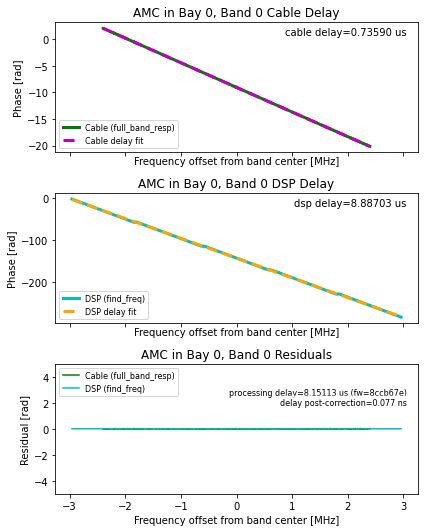

(8.887025080781674, 7.666353852075211e-05)

In [17]:
S.estimate_phase_delay(band)

Take a full band response.

[ 2022-01-14 18:54:57 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2022-01-14 18:54:57 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2022-01-14 18:54:57 ]  ADC0 max count: 8936
[ 2022-01-14 18:54:57 ]  ADC0 min count: -7540
[ 2022-01-14 18:54:57 ]  ADC0 not saturated
[ 2022-01-14 18:54:57 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2022-01-14 18:54:57 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2022-01-14 18:54:57 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2022-01-14 18:54:57 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2022-01-14 18:54:58 ]  UC (DAC) att: 0
[ 2022-01-14 18:54:58 ]  DC (ADC) att: 12
[ 2022-01-14 18:54:58 ]  DC attenuator > 0. Scaling by 1.995


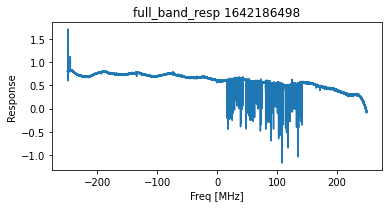

(array([-3.07200000e+08, -3.07197656e+08, -3.07195312e+08, ...,
         3.07192969e+08,  3.07195312e+08,  3.07197656e+08]),
 array([-0.00827096-0.00018956j, -0.00275902-0.00362689j,
        -0.00508339-0.00057444j, ..., -0.00588454-0.00730316j,
        -0.00446294-0.00099051j, -0.01088298+0.00020143j]))

In [29]:
S.full_band_resp(band,make_plot=True,show_plot=True)

[ 2022-01-14 18:55:05 ]  Sweeping across frequencies 4000.0MHz to 4500.0MHz
[ 2022-01-14 18:55:05 ]  Working on band 0
[ 2022-01-14 18:55:48 ]  serial find freq complete ; etaScanInProgress = 0


/usr/local/src/pysmurf/python/pysmurf/client/tune/smurf_tune.py:903: RuntimeWarning: invalid value encountered in double_scalars
  if 1-amp[idx]/med_amp[idx] > amp_cut:


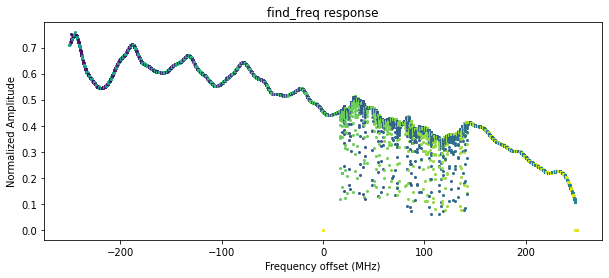

In [30]:
freqs, resps = S.find_freq(band, tone_power=12,grad_cut=0.01, amp_cut=0.1,make_plot=True,show_plot=True)

[ 2022-01-14 18:55:57 ]  No tone_power given. Using value in config file: 12
[ 2022-01-14 18:55:57 ]  freq 4266.9600 - 1 of 65
[ 2022-01-14 18:55:57 ]  freq 4268.6400 - 2 of 65
[ 2022-01-14 18:55:57 ]  freq 4270.7600 - 3 of 65
[ 2022-01-14 18:55:57 ]  freq 4271.8800 - 4 of 65
[ 2022-01-14 18:55:57 ]  freq 4273.4800 - 5 of 65
[ 2022-01-14 18:55:57 ]  freq 4275.2800 - 6 of 65
[ 2022-01-14 18:55:57 ]  freq 4277.0400 - 7 of 65
[ 2022-01-14 18:55:57 ]  freq 4279.1200 - 8 of 65
[ 2022-01-14 18:55:57 ]  freq 4281.2400 - 9 of 65
[ 2022-01-14 18:55:57 ]  freq 4283.3200 - 10 of 65
[ 2022-01-14 18:55:57 ]  freq 4285.2800 - 11 of 65
[ 2022-01-14 18:55:57 ]  freq 4286.8400 - 12 of 65
[ 2022-01-14 18:55:57 ]  freq 4289.3600 - 13 of 65
[ 2022-01-14 18:55:57 ]  freq 4290.2800 - 14 of 65
[ 2022-01-14 18:55:57 ]  freq 4291.6000 - 15 of 65
[ 2022-01-14 18:55:57 ]  freq 4293.2800 - 16 of 65
[ 2022-01-14 18:55:57 ]  freq 4298.6400 - 17 of 65
[ 2022-01-14 18:55:57 ]  freq 4300.2800 - 18 of 65
[ 2022-01-14 1

/usr/local/src/pysmurf/python/pysmurf/client/tune/smurf_tune.py:1410: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(9,4.5))


[ 2022-01-14 18:57:30 ]  Eta plot 21 of 65
[ 2022-01-14 18:57:31 ]  Eta plot 22 of 65
[ 2022-01-14 18:57:31 ]  Eta plot 23 of 65
[ 2022-01-14 18:57:32 ]  Eta plot 24 of 65
[ 2022-01-14 18:57:33 ]  Eta plot 25 of 65
[ 2022-01-14 18:57:33 ]  Eta plot 26 of 65
[ 2022-01-14 18:57:34 ]  Eta plot 27 of 65
[ 2022-01-14 18:57:34 ]  Eta plot 28 of 65
[ 2022-01-14 18:57:35 ]  Eta plot 29 of 65
[ 2022-01-14 18:57:35 ]  Eta plot 30 of 65
[ 2022-01-14 18:57:36 ]  Eta plot 31 of 65
[ 2022-01-14 18:57:37 ]  Eta plot 32 of 65
[ 2022-01-14 18:57:38 ]  Eta plot 33 of 65
[ 2022-01-14 18:57:38 ]  Eta plot 34 of 65
[ 2022-01-14 18:57:39 ]  Eta plot 35 of 65
[ 2022-01-14 18:57:39 ]  Eta plot 36 of 65
[ 2022-01-14 18:57:40 ]  Eta plot 37 of 65
[ 2022-01-14 18:57:40 ]  Eta plot 38 of 65
[ 2022-01-14 18:57:41 ]  Eta plot 39 of 65
[ 2022-01-14 18:57:42 ]  Eta plot 40 of 65
[ 2022-01-14 18:57:42 ]  Eta plot 41 of 65
[ 2022-01-14 18:57:43 ]  Eta plot 42 of 65
[ 2022-01-14 18:57:44 ]  Eta plot 43 of 65
[ 2022-01-1

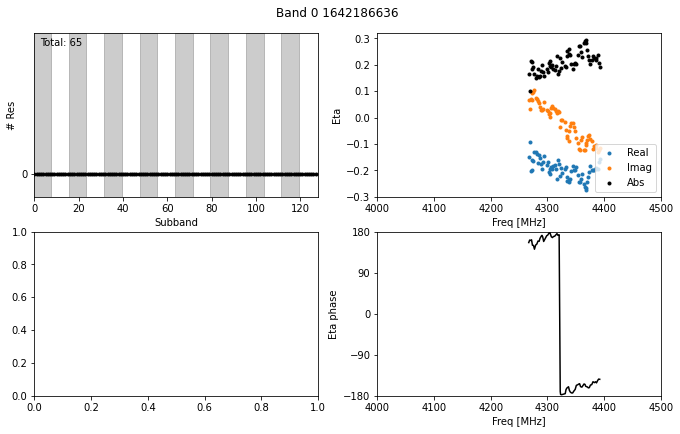

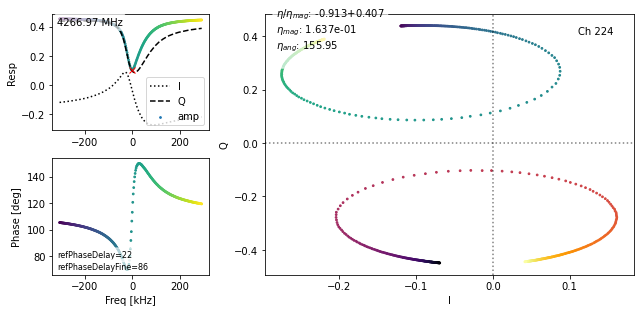

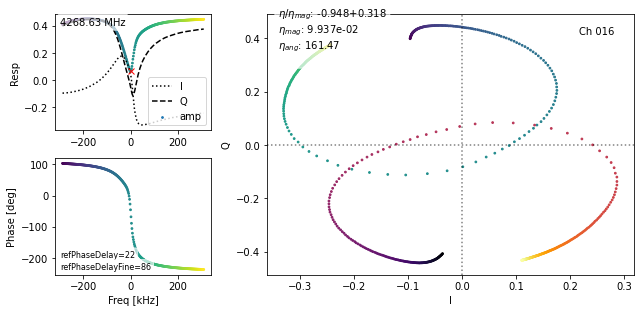

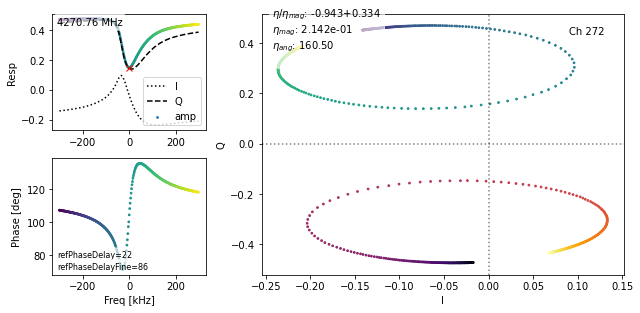

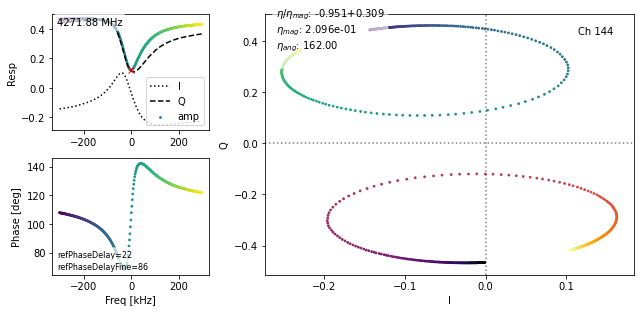

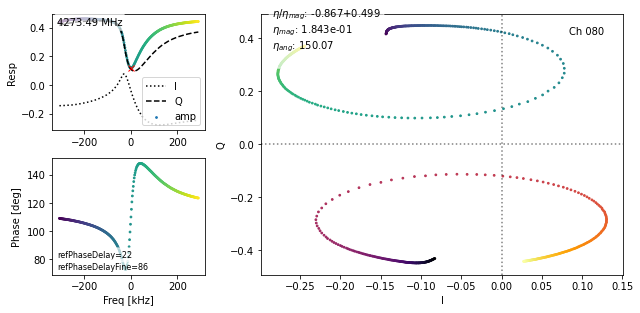

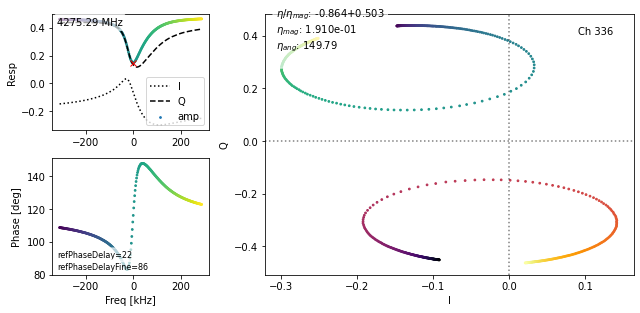

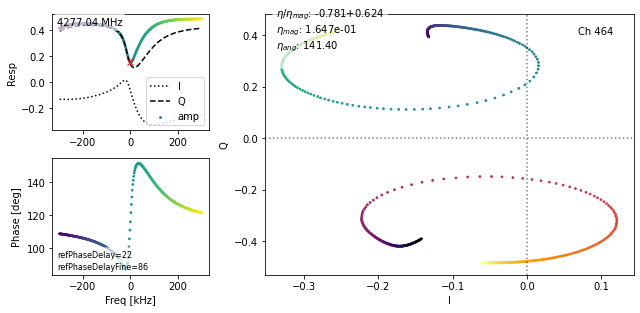

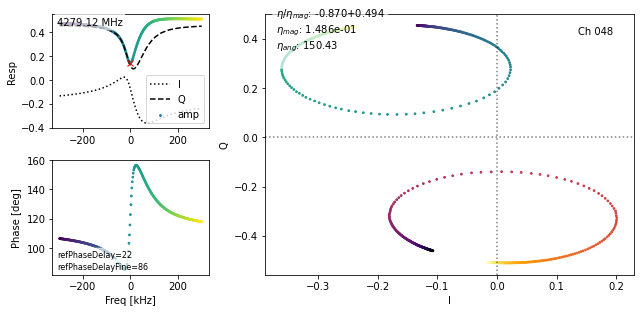

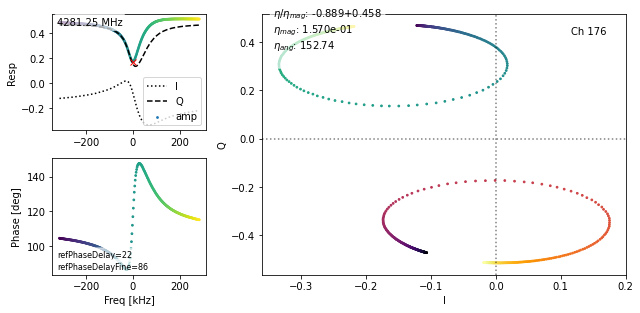

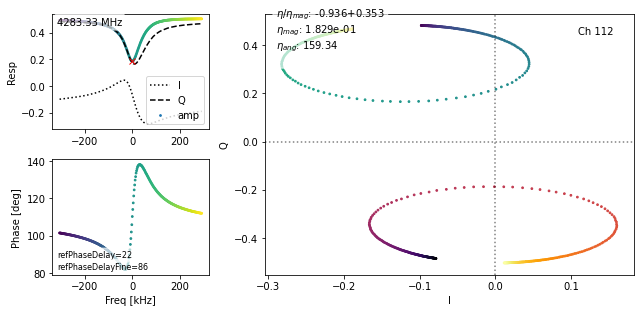

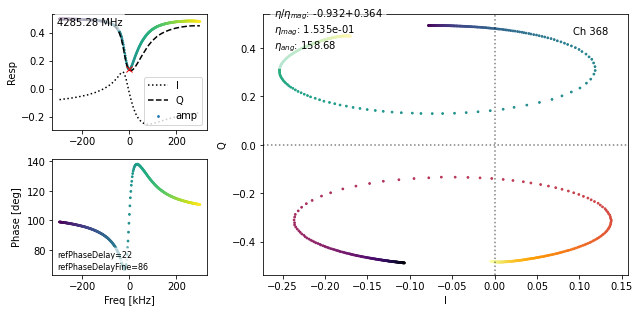

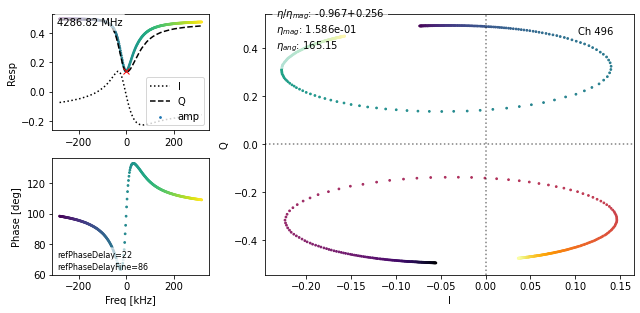

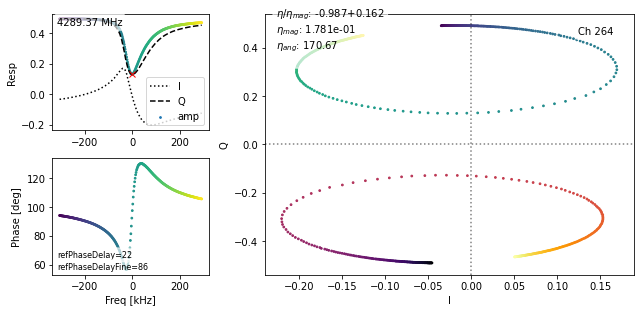

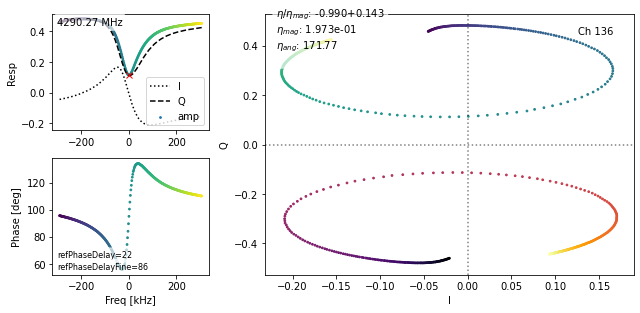

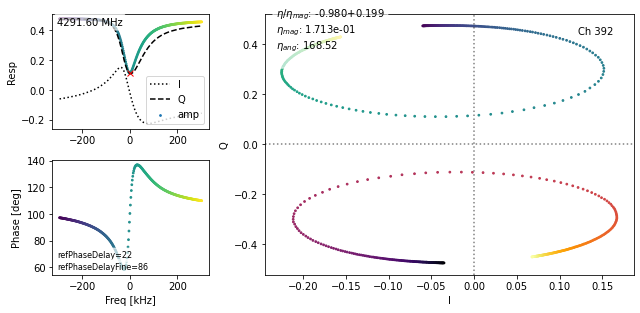

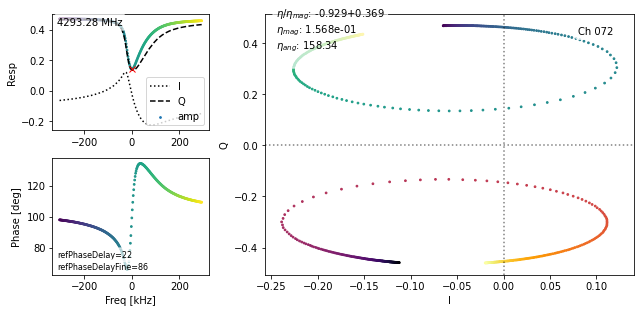

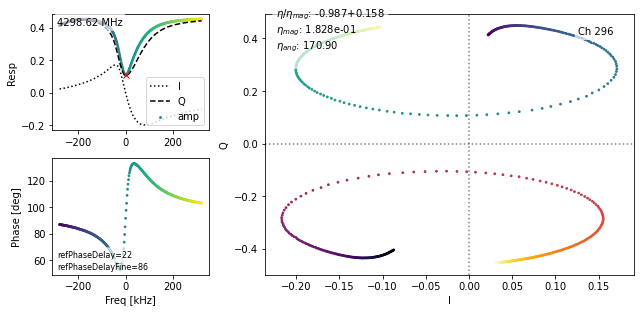

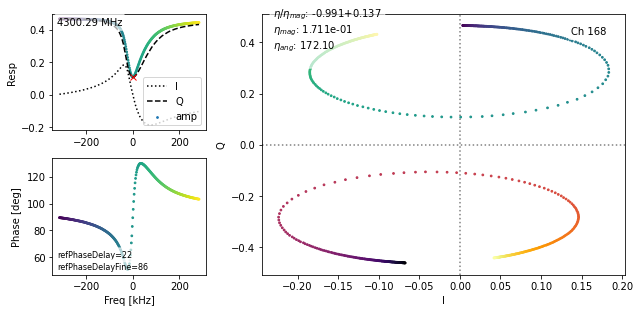

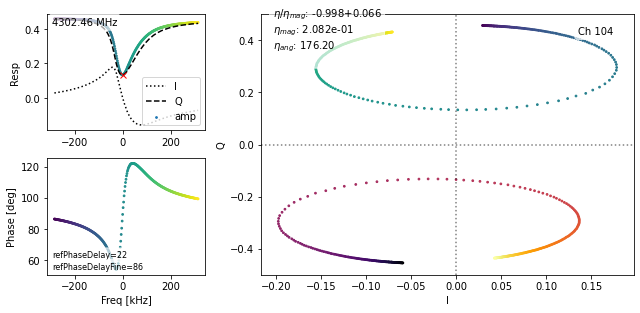

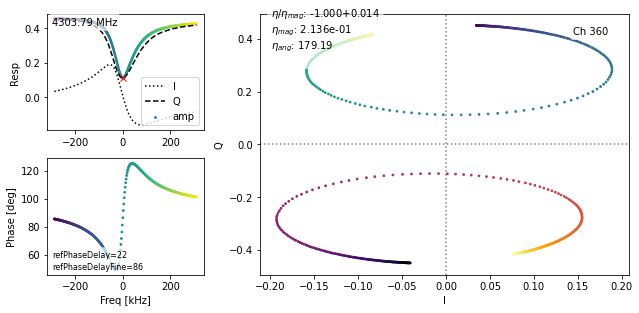

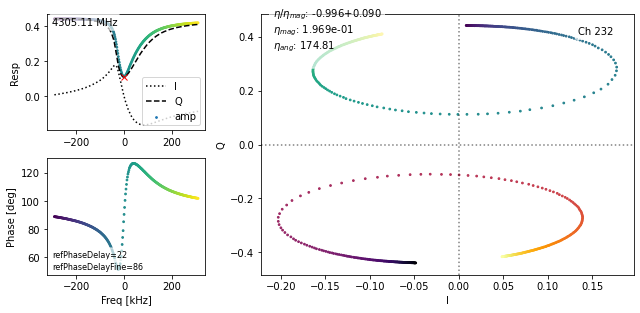

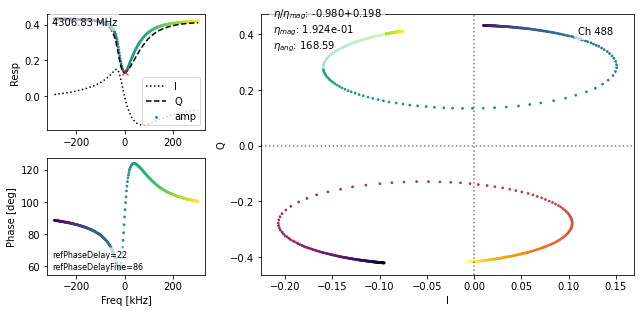

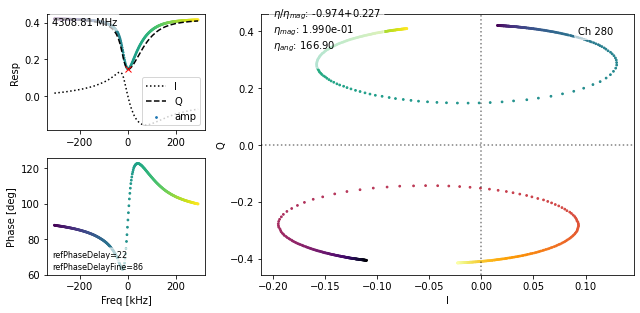

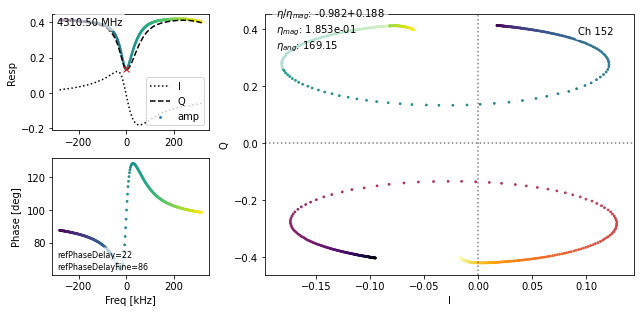

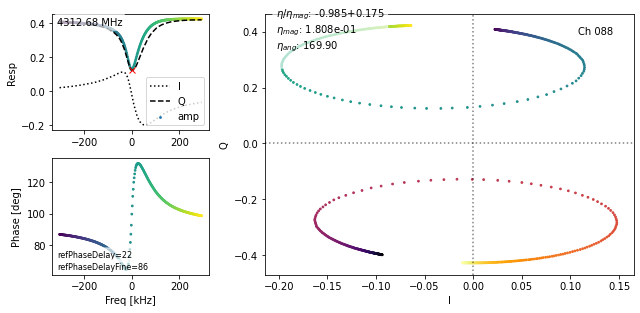

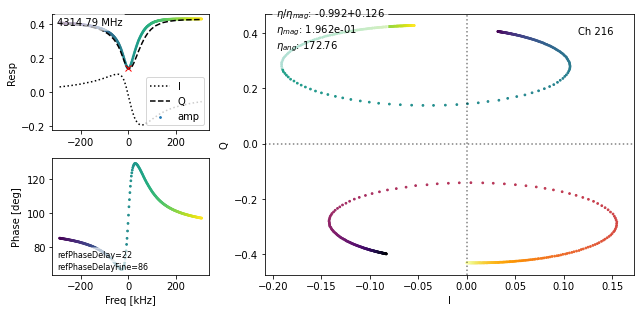

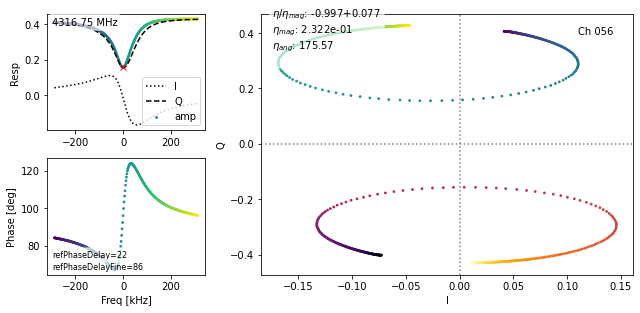

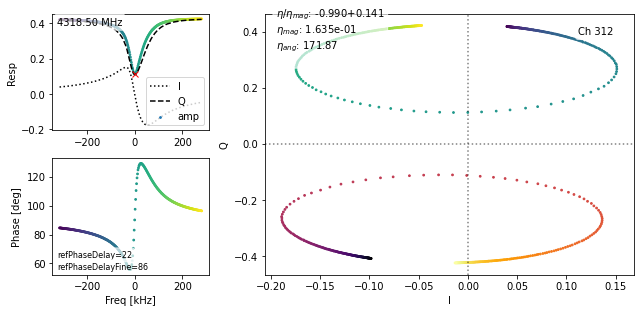

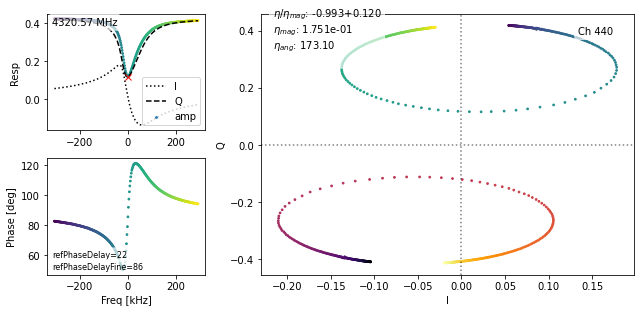

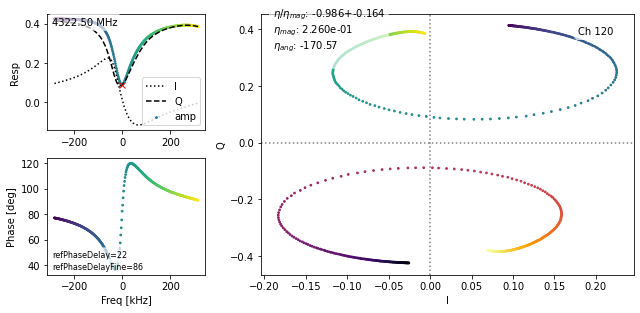

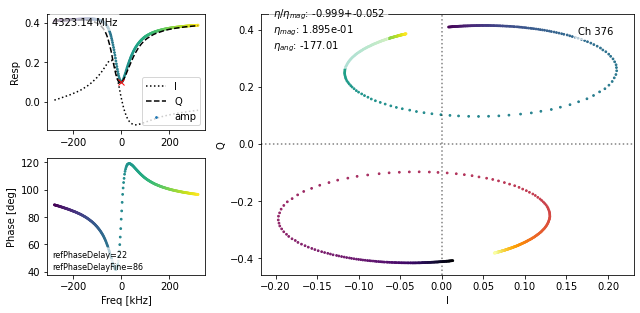

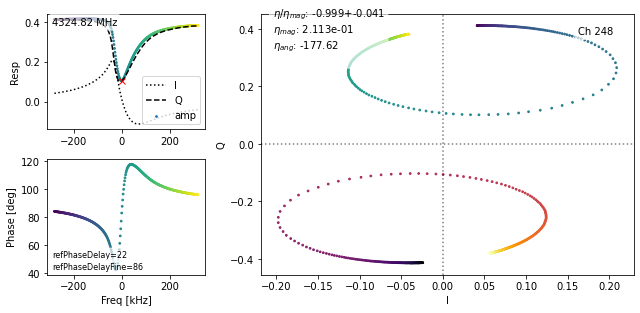

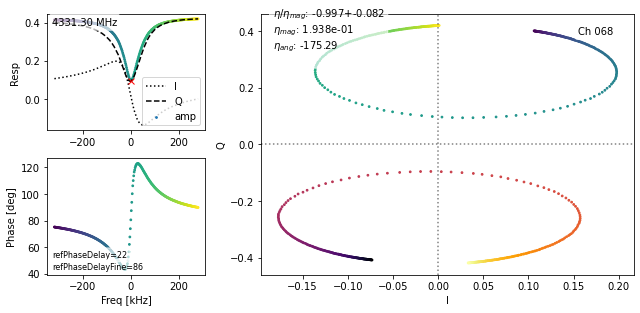

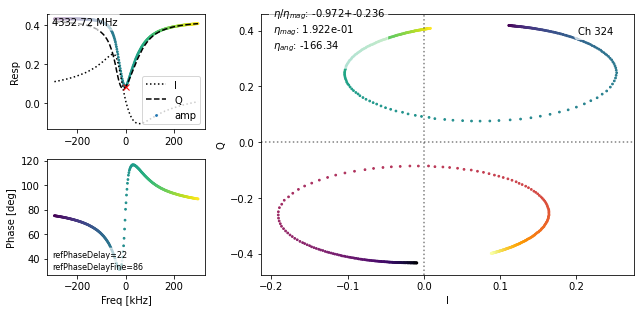

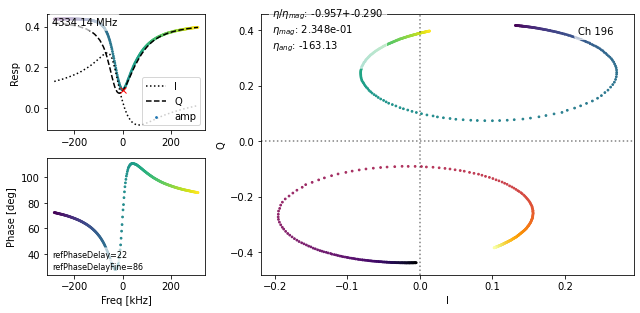

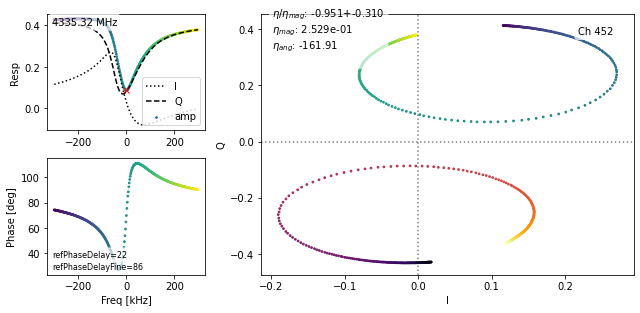

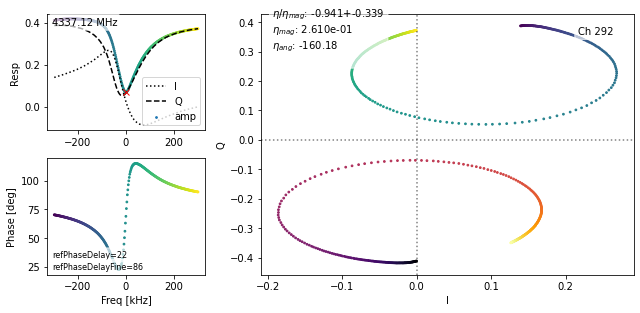

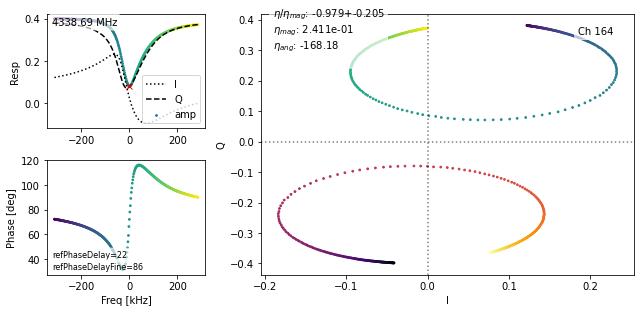

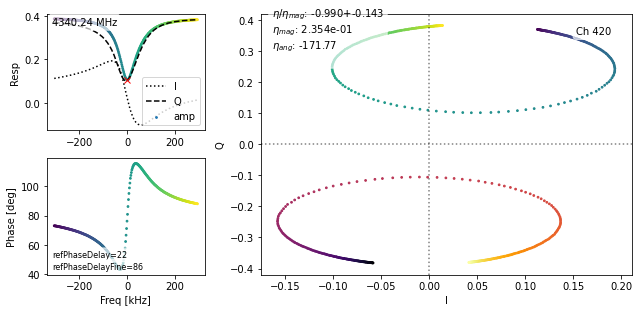

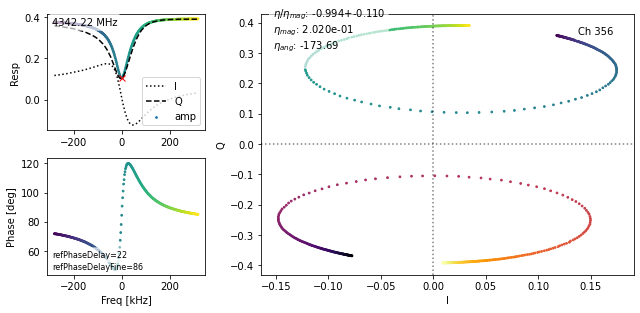

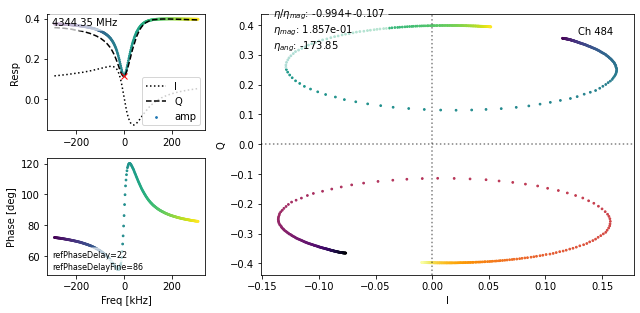

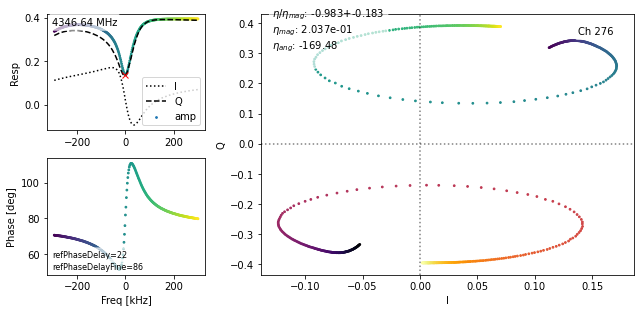

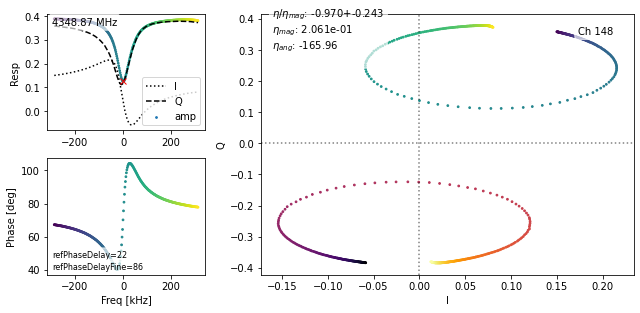

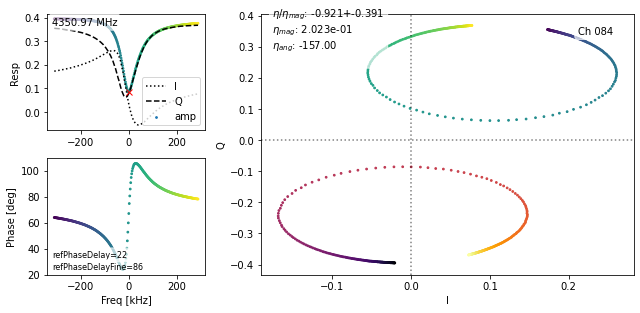

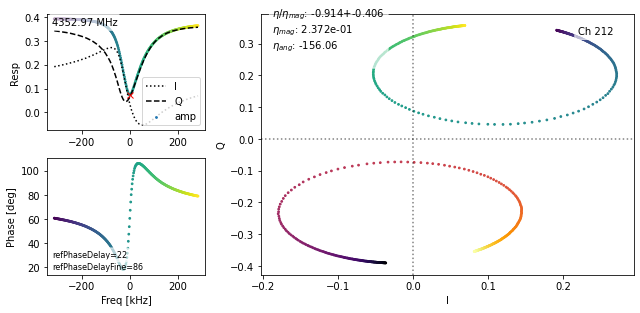

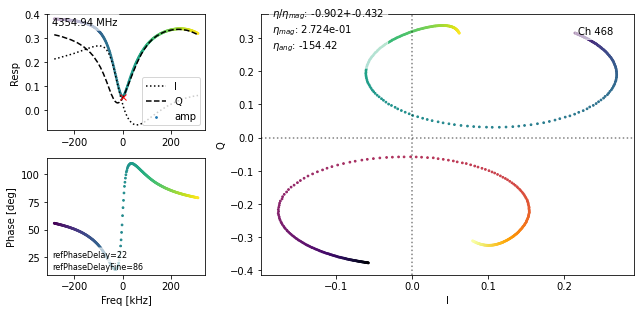

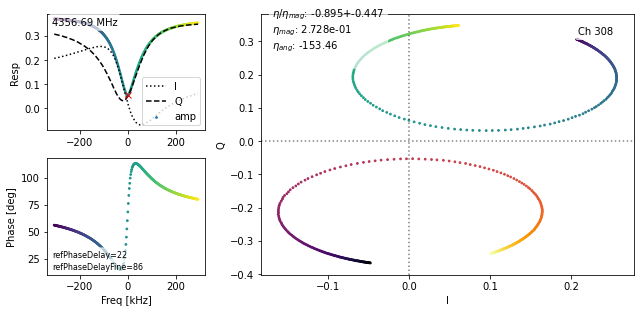

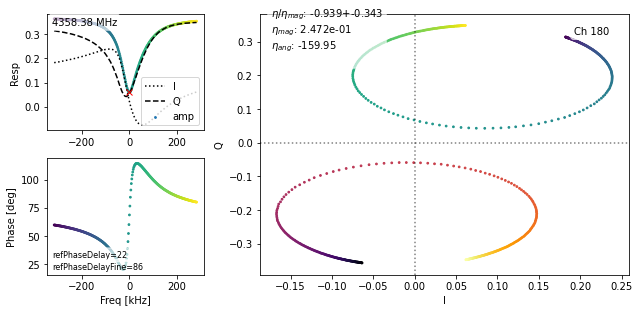

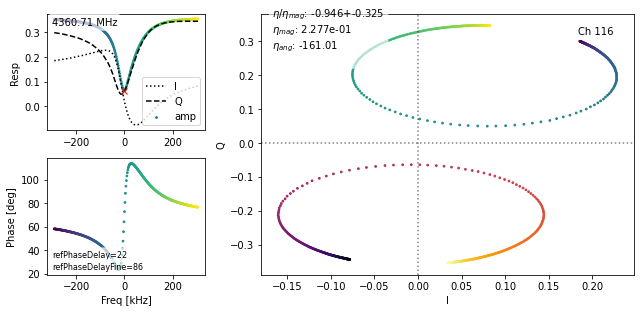

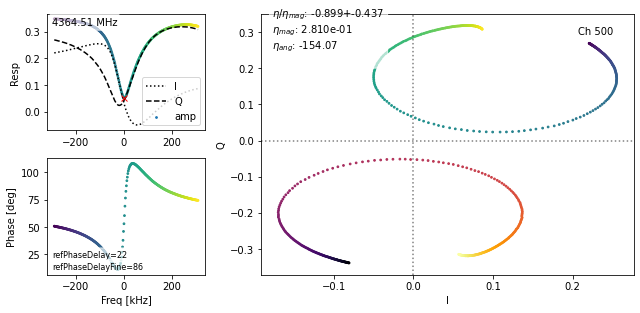

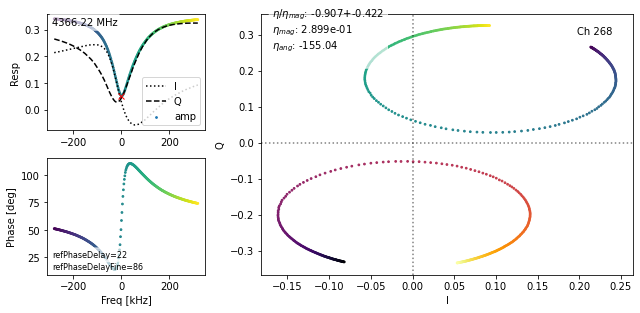

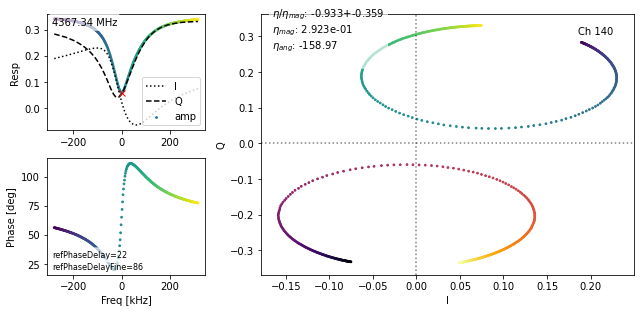

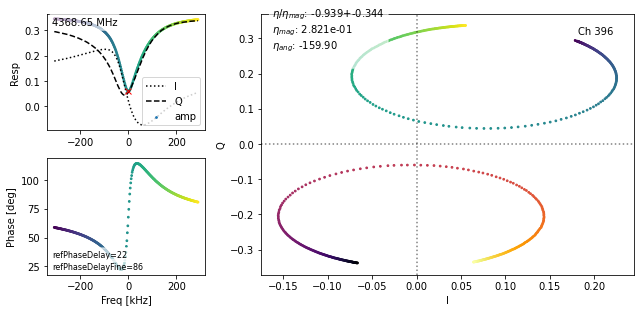

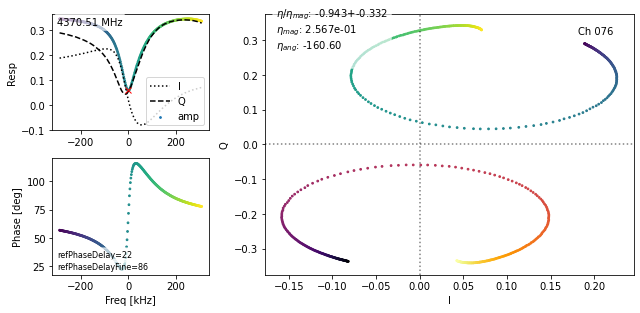

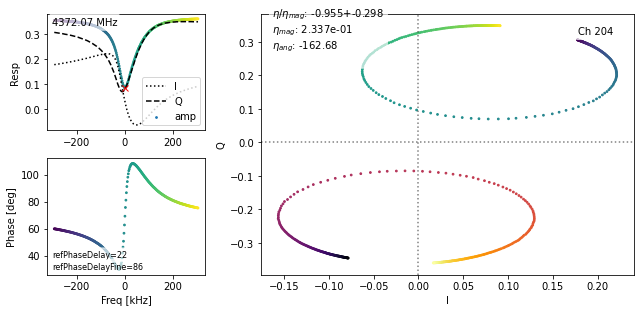

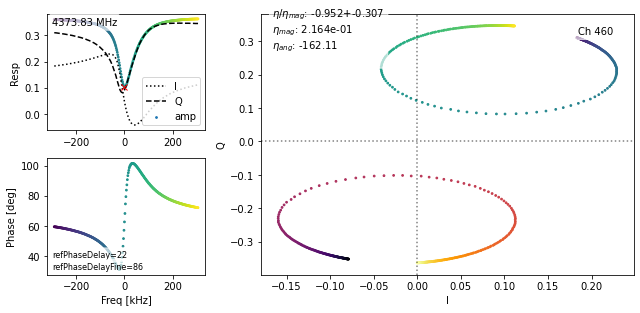

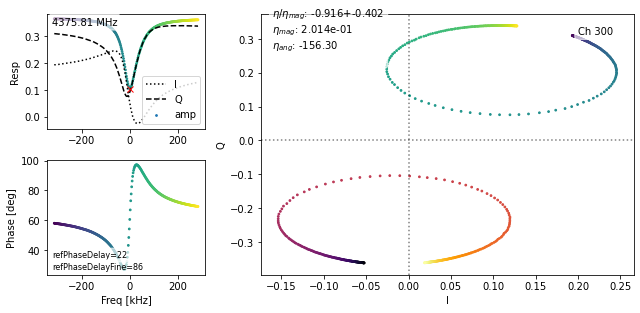

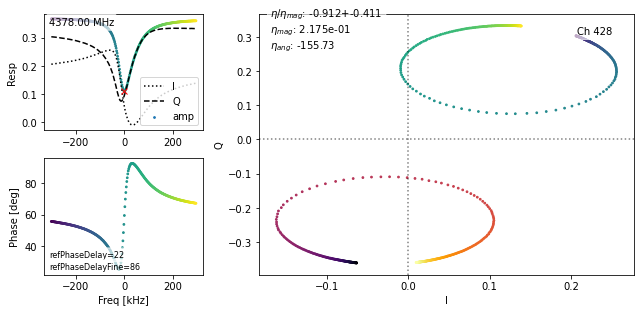

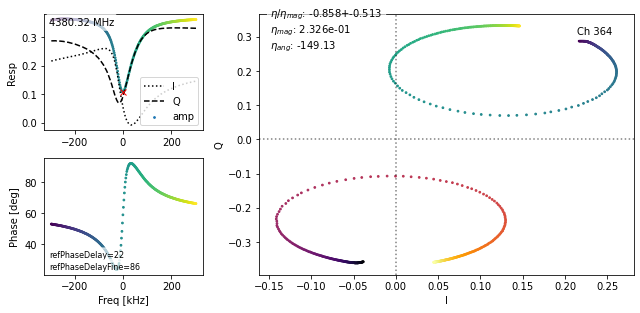

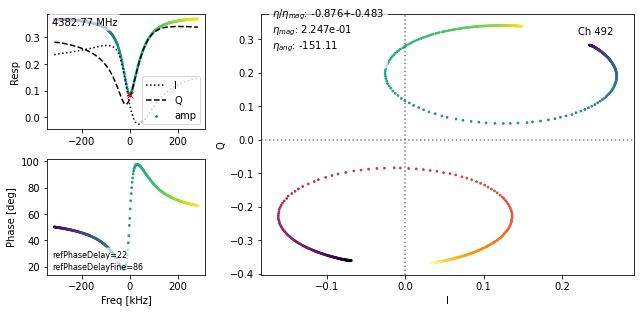

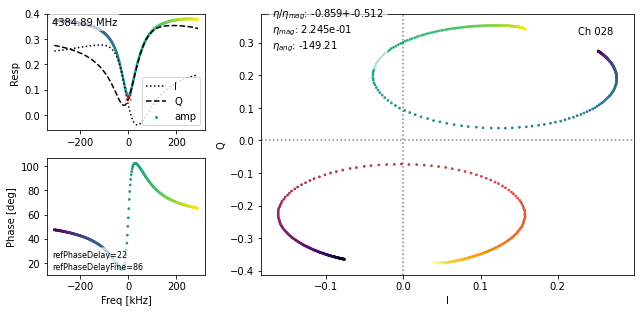

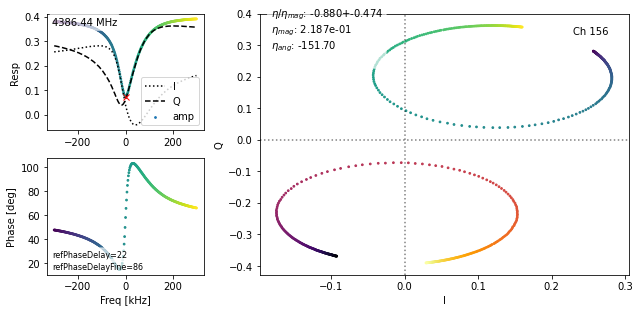

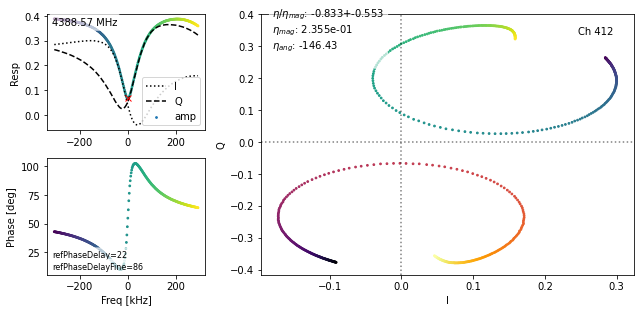

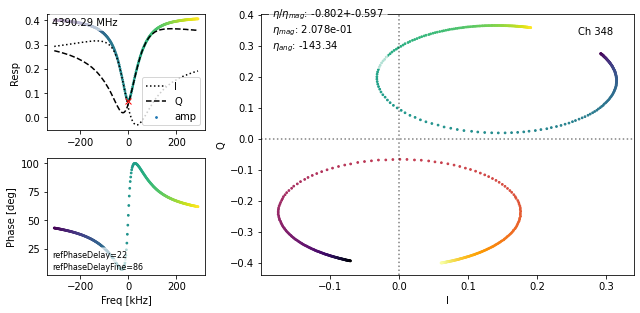

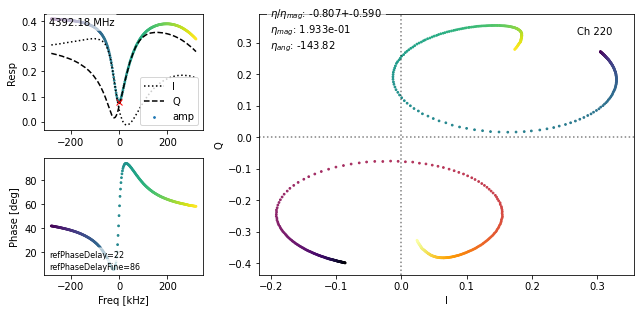

In [31]:
# Tune
S.setup_notches(band,new_master_assignment=True)

# Refine tuning
S.run_serial_gradient_descent(band)
S.run_serial_eta_scan(band)
S.plot_tune_summary(band,eta_scan=True,show_plot=True)

Set AC flux ramp mode

In [32]:
S.set_cryo_card_relay_bit(16,0)
bin(S.get_cryo_card_relays())

'0b0'

Tracking setup

[ 2022-01-14 19:03:13 ]  Using LMS gain is now an advanced feature.
[ 2022-01-14 19:03:13 ]  Unless you are an expert, you probably want feedback_gain.
[ 2022-01-14 19:03:13 ]  See tracking_setup docstring.
[ 2022-01-14 19:03:13 ]  Starting fraction full scale : 0.184
[ 2022-01-14 19:03:13 ]  Percent full scale = 18.362%
[ 2022-01-14 19:03:13 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadout 0
[ 2022-01-14 19:03:13 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadoutOpt2 0
[ 2022-01-14 19:03:13 ]  Writing to file : /data/smurf_data/20220114/1642185252/outputs/1642186994.dat
[ 2022-01-14 19:03:13 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2022-01-14 19:03:13 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2022-01-14 19:03:13 ]  Data acquisition in progress...
[ 2022-01-14 19:03:13 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:A

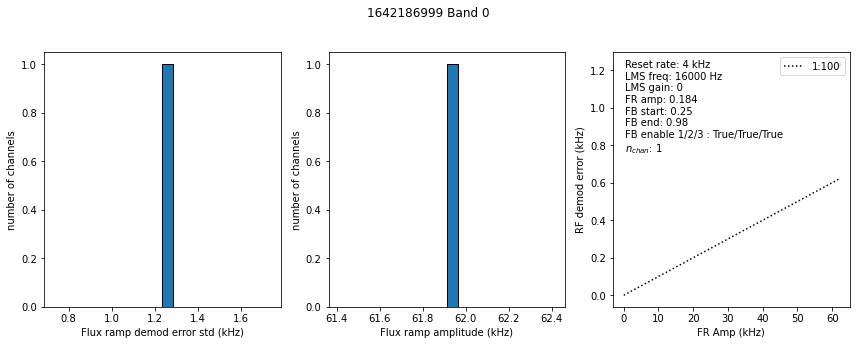

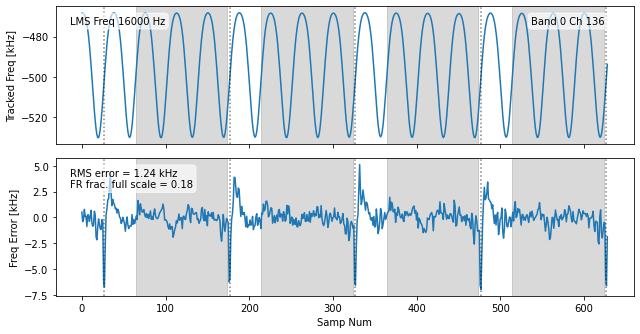

In [38]:
 S.tracking_setup(band, channel = S.which_on(band), reset_rate_khz=4, make_plot=True, save_plot=True, show_plot=True, 
                  lms_freq_hz=None, n_phi0=4, meas_flux_ramp_amp=True, fraction_full_scale=0.2,feedback_gain=2048,lms_gain=0,
                  return_data=False, feedback_start_frac=0.25, feedback_end_frac=0.98,nsamp = 2**18)

Check lock

In [34]:
S.check_lock(band)

[ 2022-01-14 18:59:08 ]  Checking lock on band 0
[ 2022-01-14 18:59:08 ]  Currently 65 channels on
[ 2022-01-14 18:59:08 ]  Using LMS gain is now an advanced feature.
[ 2022-01-14 18:59:08 ]  Unless you are an expert, you probably want feedback_gain.
[ 2022-01-14 18:59:08 ]  See tracking_setup docstring.
[ 2022-01-14 18:59:08 ]  Percent full scale = 18.362%
[ 2022-01-14 18:59:08 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadout 0
[ 2022-01-14 18:59:08 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:SysgenCryo:Base[0]:singleChannelReadoutOpt2 0
[ 2022-01-14 18:59:08 ]  Writing to file : /data/smurf_data/20220114/1642185252/outputs/1642186749.dat
[ 2022-01-14 18:59:08 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 524288
[ 2022-01-14 18:59:09 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2022-01-14 18:59:09 ]  Data acquisition in progress...
[ 2022-01-14 18:59:09 ]  capu

Check RF ADC and DAC for saturation.

In [35]:
S.check_adc_saturation(band)
S.check_dac_saturation(band)

[ 2022-01-14 18:59:15 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2022-01-14 18:59:15 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2022-01-14 18:59:15 ]  ADC0 max count: 4338
[ 2022-01-14 18:59:15 ]  ADC0 min count: -4939
[ 2022-01-14 18:59:15 ]  ADC0 not saturated
[ 2022-01-14 18:59:15 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:DaqMuxV2[0]:DataBufferSize 4096
[ 2022-01-14 18:59:15 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:DebugSelect[0] 0
[ 2022-01-14 18:59:15 ]  DAC0 max count: 8652
[ 2022-01-14 18:59:15 ]  DAC0 min count: -9759
[ 2022-01-14 18:59:15 ]  DAC0 not saturated


False

Take noise data.

[ 2022-01-14 19:06:26 ]  Starting to take data.
[ 2022-01-14 19:06:26 ]  Input downsample factor is None. Using value already in pyrogue: 20
[ 2022-01-14 19:06:26 ]  Flux ramp is AC-coupled.
[ 2022-01-14 19:06:26 ]  caput smurf_server_s4:AMCc:SmurfProcessor:Unwrapper:reset 1
[ 2022-01-14 19:06:26 ]  caput smurf_server_s4:AMCc:SmurfProcessor:Filter:reset 1
[ 2022-01-14 19:06:26 ]  Writing to file : /data/smurf_data/20220114/1642185252/outputs/1642187187.dat
[ 2022-01-14 19:06:28 ]  /data/smurf_data/20220114/1642185252/outputs/1642187187_mask.txt
[ 2022-01-14 19:06:28 ]  Writing frequency mask.
[ 2022-01-14 19:06:28 ]  caput smurf_server_s4:AMCc:SmurfProcessor:FileWriter:Open 1
[ 2022-01-14 19:16:28 ]  caput smurf_server_s4:AMCc:SmurfProcessor:FileWriter:Close 1
[ 2022-01-14 19:16:28 ]  caput smurf_server_s4:AMCc:FpgaTopLevel:AppTop:AppCore:enableStreaming 0
[ 2022-01-14 19:16:28 ]  Waiting 0.15 seconds after...
[ 2022-01-14 19:16:28 ]  Done waiting.
[ 2022-01-14 19:16:28 ]  Done taking 

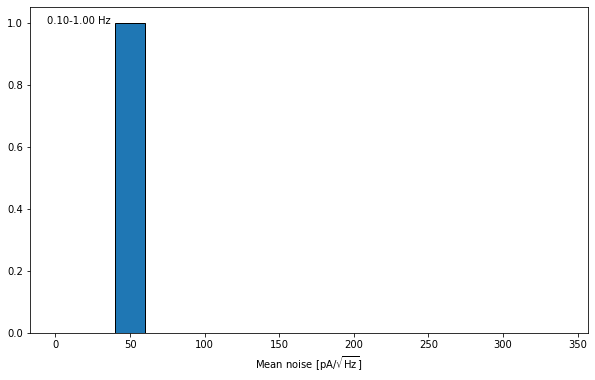

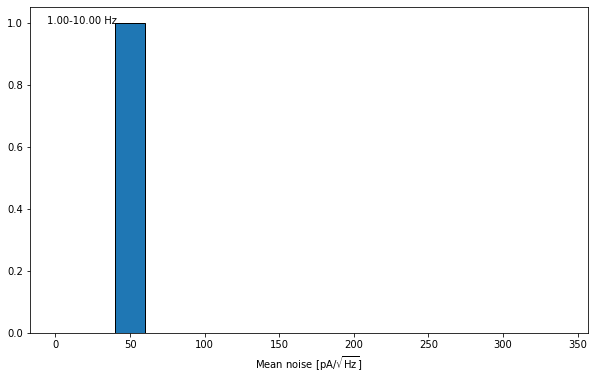

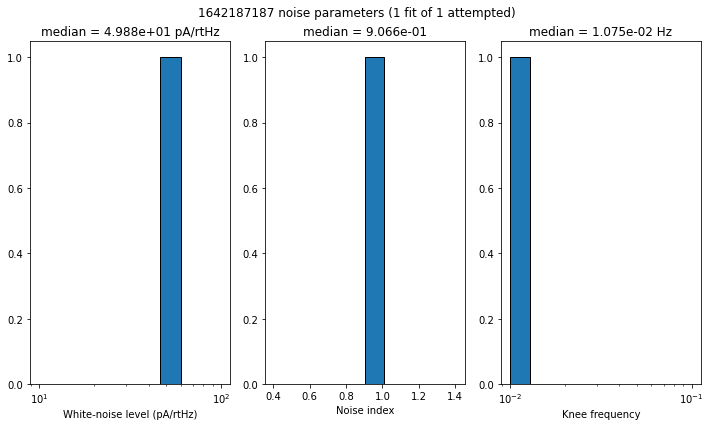

'/data/smurf_data/20220114/1642185252/outputs/1642187187.dat'

In [41]:
S.take_noise_psd(600,show_plot=True)

In [37]:
for chan in S.which_on(0):
    if chan!=136:
        S.channel_off(0,chan)

[ 2022-01-14 19:02:52 ]  Turning off band 0 channel 16
[ 2022-01-14 19:02:52 ]  Turning off band 0 channel 28
[ 2022-01-14 19:02:52 ]  Turning off band 0 channel 48
[ 2022-01-14 19:02:52 ]  Turning off band 0 channel 56
[ 2022-01-14 19:02:52 ]  Turning off band 0 channel 68
[ 2022-01-14 19:02:53 ]  Turning off band 0 channel 72
[ 2022-01-14 19:02:53 ]  Turning off band 0 channel 76
[ 2022-01-14 19:02:53 ]  Turning off band 0 channel 80
[ 2022-01-14 19:02:53 ]  Turning off band 0 channel 84
[ 2022-01-14 19:02:53 ]  Turning off band 0 channel 88
[ 2022-01-14 19:02:53 ]  Turning off band 0 channel 104
[ 2022-01-14 19:02:53 ]  Turning off band 0 channel 112
[ 2022-01-14 19:02:53 ]  Turning off band 0 channel 116
[ 2022-01-14 19:02:53 ]  Turning off band 0 channel 120
[ 2022-01-14 19:02:53 ]  Turning off band 0 channel 140
[ 2022-01-14 19:02:53 ]  Turning off band 0 channel 144
[ 2022-01-14 19:02:53 ]  Turning off band 0 channel 148
[ 2022-01-14 19:02:53 ]  Turning off band 0 channel 152
[ 